In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from glob import glob
import pandas as pd
from skimage import img_as_float
from skimage.filters import gaussian
from skimage.segmentation import active_contour
from skimage.measure import find_contours
from skimage.segmentation import watershed
from skimage.filters import threshold_otsu
from skimage import img_as_ubyte

### ABCF 이미지 로드

In [3]:
def show_image(image, title='Image'):
    if image is not None:
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title(title)
        plt.axis('off')
        plt.show()

In [4]:
def show_image_new(image, title='Image'):
    # 이미지를 uint8 형식으로 변환
    image_uint8 = (image * 255).astype(np.uint8)
    
    # 이미지 출력
    if image_uint8 is not None:
        plt.imshow(cv2.cvtColor(image_uint8, cv2.COLOR_BGR2RGB))
        plt.title(title)
        plt.axis('off')
        plt.show()
    else:
        print("이미지를 불러올 수 없습니다.")

In [5]:
def load_images_in_folder(folder_path):
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.jpeg', '.png', '.gif'))]
    images = {}
    for image_file in image_files:
        image_path = os.path.join(folder_path, image_file)
        images[image_file] = image_path
    return images

In [6]:
def load_images_in_folders(folders):
    images_in_folders = {}
    for folder_name, folder_path in folders.items():
        images_in_folders[folder_name] = load_images_in_folder(folder_path)
    return images_in_folders


In [7]:
folder_A = "A"
folder_B = "B"
folder_C = "C"
folder_F = "F"
folders = {
    'A': folder_A,
    'B': folder_B,
    'C': folder_C,
    'F': folder_F
}

In [8]:
images_in_folders = load_images_in_folders(folders)

In [9]:
images_in_folders

{'A': {'setimg6_sb_381_Liniya 1id61_2393.png': 'A/setimg6_sb_381_Liniya 1id61_2393.png',
  'Liniya 1id331_6385.png': 'A/Liniya 1id331_6385.png',
  'setimg6_sb_400_Liniya 1id68_2470.png': 'A/setimg6_sb_400_Liniya 1id68_2470.png',
  'setimg6_sb_354_Liniya 1id53_2044.png': 'A/setimg6_sb_354_Liniya 1id53_2044.png',
  'setimg5_labeling_196_Liniya 1id85_2227.png': 'A/setimg5_labeling_196_Liniya 1id85_2227.png',
  'setimg6_sb_247_Liniya 1id15_835.png': 'A/setimg6_sb_247_Liniya 1id15_835.png',
  'setimg5_labeling_194_Liniya 1id49_1451.png': 'A/setimg5_labeling_194_Liniya 1id49_1451.png',
  'setimg6_sb_379_Liniya 1id61_2372.png': 'A/setimg6_sb_379_Liniya 1id61_2372.png',
  'setimg6_sb_278_Liniya 1id23_902.png': 'A/setimg6_sb_278_Liniya 1id23_902.png',
  'setimg4_labelimg_20_Liniya 1id271_5134.png': 'A/setimg4_labelimg_20_Liniya 1id271_5134.png',
  'setimg6_sb_305_Liniya 1id2_460.png': 'A/setimg6_sb_305_Liniya 1id2_460.png',
  'setimg6_sb_314_Liniya 1id3_146.png': 'A/setimg6_sb_314_Liniya 1id3_1

In [325]:
contour_folder = "contours_small"
os.makedirs(contour_folder, exist_ok=True)

In [419]:
for label, images in images_in_folders.items():
    for image_name, image_path in images.items():
        # 이미지 로드
        image = cv2.imread(image_path)
        if image is None:
            print(f"Warning: {image_path} 이미지를 읽을 수 없습니다.")
            continue
        
        # 그레이스케일 변환
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        # 이진화
        _, binary = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY_INV)
        
        # 컨투어 검출
        contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        # 이미지의 너비를 가져오기
        height, width = binary.shape[:2]
        
        # 작은 컨투어만 고려 
        min_contour_area = width * 0.01  # 이미지 너비의 1%로 작은 컨투어의 최소 면적 설정
        max_contour_area = width * 0.3   

        # 작은 컨투어만 고려하여 컨투어 그리기
        for contour in contours:
            area = cv2.contourArea(contour)
            if min_contour_area <= area <= max_contour_area:
                # 컨투어 그리기
                for i in range(len(contour) - 1):
                    cv2.line(image, (contour[i][0][0], contour[i][0][1]),
                             (contour[i+1][0][0], contour[i+1][0][1]), (0, 255, 0), 2)
        
        # 이미지 저장
        contour_image_path = os.path.join(contour_folder, f"{label}_{image_name}")
        cv2.imwrite(contour_image_path, image)


### 이미지 전처리 및 컨투어 통계 함수

In [420]:
import cv2
import numpy as np

def process_image(image_path):
    # 이미지 로드
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"이미지를 로드할 수 없습니다: {image_path}")

    # 그레이스케일 변환
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # 이진화
    _, binary = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY_INV)
    
    # 이미지의 너비를 가져오기
    height, width = binary.shape[:2]
    
    # 차선 면적
    image_area = np.count_nonzero(binary)

    # 작은 컨투어의 최소 및 최대 면적 설정
    min_contour_area = width * 0.01  # 이미지 너비의 1%로 작은 컨투어의 최소 면적 설정
    max_contour_area = width * 0.3   # 이미지 너비의 30%로 작은 컨투어의 최대 면적 설정

    # 컨투어 검출
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # 이미지 전체 면적을 고려하여 작은 컨투어 필터링
    small_contours = [c for c in contours if min_contour_area <= cv2.contourArea(c) <= max_contour_area]

    # 컨투어 면적 계산
    contour_areas = [cv2.contourArea(c) for c in small_contours]
    total_contour_area = sum(contour_areas)
    print(total_contour_area)

    # 통계 계산
    num_contours = len(small_contours)
    variance_contour_area = np.var(contour_areas) if contour_areas else 0
    contour_area_ratio = total_contour_area / image_area if image_area > 0 else 0

    return {
        "num_contours": num_contours,
        "variance_contour_area": variance_contour_area,
        "contour_area_ratio": contour_area_ratio
    }


In [421]:
# 컨투어 개수(num_contours):

# 예를 들어, 첫 번째 이미지에서는 5개의 컨투어를 찾았고, 두 번째 이미지에서는 8개의 컨투어를 찾았다고 가정합니다. 이 경우 num_contours 값은 각각 5와 8이 됩니다.
# 컨투어 면적의 분산(variance_contour_area):

# 각 이미지에서 컨투어 면적을 계산합니다.
# 예를 들어, 첫 번째 이미지의 컨투어 면적이 [100, 150, 200, 250, 300]이라면, 이 값들의 분산을 계산합니다. 분산은 해당 데이터셋에서 값들이 평균으로부터 얼마나 퍼져 있는지를 나타냅니다.
# 두 번째 이미지의 경우에도 마찬가지로 컨투어 면적을 계산하고 분산을 구합니다.
# 이런식으로 각 이미지에서 계산된 컨투어 면적의 분산값을 이용하여 전체적인 분산을 구합니다.
# 컨투어 면적 비율(contour_area_ratio):

# 이미지 전체 면적을 구합니다. 이는 이미지의 너비와 높이를 곱한 값입니다.
# 컨투어들의 총 면적을 구합니다. 이는 각 이미지에서 찾은 컨투어들의 면적을 모두 더한 값입니다.
# 각 이미지의 컨투어 면적 총합을 이미지 전체 면적으로 나누어서 컨투어 면적의 비율을 구합니다.
# 이 비율은 해당 이미지에서 컨투어가 차지하는 비율을 나타냅니다.

<!-- 컨투어 개수(num_contours):

예를 들어, 첫 번째 이미지에서는 5개의 컨투어를 찾았고, 두 번째 이미지에서는 8개의 컨투어를 찾았다고 가정합니다. 이 경우 num_contours 값은 각각 5와 8이 됩니다.
컨투어 면적의 분산(variance_contour_area):

각 이미지에서 컨투어 면적을 계산합니다.
예를 들어, 첫 번째 이미지의 컨투어 면적이 [100, 150, 200, 250, 300]이라면, 이 값들의 분산을 계산합니다. 분산은 해당 데이터셋에서 값들이 평균으로부터 얼마나 퍼져 있는지를 나타냅니다.
두 번째 이미지의 경우에도 마찬가지로 컨투어 면적을 계산하고 분산을 구합니다.
이런식으로 각 이미지에서 계산된 컨투어 면적의 분산값을 이용하여 전체적인 분산을 구합니다.
컨투어 면적 비율(contour_area_ratio):

이미지 전체 면적을 구합니다. 이는 이미지의 너비와 높이를 곱한 값입니다.
컨투어들의 총 면적을 구합니다. 이는 각 이미지에서 찾은 컨투어들의 면적을 모두 더한 값입니다.
각 이미지의 컨투어 면적 총합을 이미지 전체 면적으로 나누어서 컨투어 면적의 비율을 구합니다.
이 비율은 해당 이미지에서 컨투어가 차지하는 비율을 나타냅니다. -->

### 훼손도 평가 함수

In [422]:
def evaluate_by_contour_count(stats, low_threshold, high_threshold):
    num_contours = stats['num_contours']
    if num_contours < low_threshold:
        return "A"
    elif low_threshold <= num_contours < high_threshold:
        return "C"
    else:
        return "F"

def evaluate_by_variance(stats, low_threshold, high_threshold):
    variance_contour_area = stats['variance_contour_area']
    if variance_contour_area < low_threshold:
        return "A"
    elif low_threshold <= variance_contour_area < high_threshold:
        return "C"
    else:
        return "F"

def evaluate_by_area_ratio(stats, low_threshold, high_threshold):
    contour_area_ratio = stats['contour_area_ratio']
    if contour_area_ratio < low_threshold:
        return "A"
    elif low_threshold <= contour_area_ratio < high_threshold:
        return "C"
    else:
        return "F"

### 전체 이미지 평가 함수

In [423]:
def evaluate_all_images(images_in_folders, low_thresh_counts, high_thresh_counts, low_thresh_var, high_thresh_var, low_thresh_ratio, high_thresh_ratio):
    results = []
    for label, images in images_in_folders.items():
        print(f"Processing label: {label}")
        for image_name, image_path in images.items():
            stats = process_image(image_path)
            count_assessment = evaluate_by_contour_count(stats, low_thresh_counts, high_thresh_counts)
            variance_assessment = evaluate_by_variance(stats, low_thresh_var, high_thresh_var)
            ratio_assessment = evaluate_by_area_ratio(stats, low_thresh_ratio, high_thresh_ratio)
            
            print(f"이미지: {image_name}")
            print(f"  컨투어 개수: {stats['num_contours']}")
            print(f"  컨투어 면적 분산: {stats['variance_contour_area']}")
            print(f"  컨투어 면적 비율: {stats['contour_area_ratio']}")
            print(f"  컨투어 개수에 따른 훼손도 평가: {count_assessment}")
            print(f"  면적 분산에 따른 훼손도 평가: {variance_assessment}")
            print(f"  면적 비율에 따른 훼손도 평가: {ratio_assessment}")
            print()
            
            results.append({
                "레이블": label,
                "이미지_이름": image_name,
                "컨투어_개수": stats['num_contours'],
                "컨투어_면적_분산": stats['variance_contour_area'],
                "컨투어_면적_비율": stats['contour_area_ratio'],
                "컨투어_개수_훼손도": count_assessment,
                "면적_분산_훼손도": variance_assessment,
                "면적_비율_훼손도": ratio_assessment
            })
    df_results = pd.DataFrame(results)
    return df_results

### 혼동행렬

In [424]:
def evaluate_results(df_results, measure):
    # 레이블과 메트릭 이름을 정의합니다.
    labels = ['A', 'C', 'F']  # B 레이블 제외
    metrics = ['Precision', 'Recall', 'Accuracy', 'F1 Score']
    results = []

    # 각 레이블에 대해 Precision, Recall, Accuracy, F1 Score을 계산합니다.
    for label in labels:
        # B 레이블을 A 레이블로 처리하여 계산
        if label == 'A':
            true_positive = len(df_results[(df_results['레이블'].isin(['A', 'B'])) & (df_results[measure] == label)])
            false_positive = len(df_results[(df_results['레이블'].isin(['C', 'F'])) & (df_results[measure] == label)])
            false_negative = len(df_results[(df_results['레이블'].isin(['A', 'B'])) & (df_results[measure] != label)])
            true_negative = len(df_results[(df_results['레이블'].isin(['C', 'F'])) & (df_results[measure] != label)])
        else:
            true_positive = len(df_results[(df_results['레이블'] == label) & (df_results[measure] == label)])
            false_positive = len(df_results[(df_results['레이블'] != label) & (df_results[measure] == label)])
            false_negative = len(df_results[(df_results['레이블'] == label) & (df_results[measure] != label)])
            true_negative = len(df_results[(df_results['레이블'] != label) & (df_results[measure] != label)])

        # Precision 계산 후 예외 처리합니다.
        try:
            precision = true_positive / (true_positive + false_positive)
        except ZeroDivisionError:
            precision = 0.0
        
        # Recall 계산 후 예외 처리합니다.
        try:
            recall = true_positive / (true_positive + false_negative)
        except ZeroDivisionError:
            recall = 0.0
        
        # Accuracy 계산 후 예외 처리합니다.
        try:
            accuracy = (true_positive + true_negative) / (true_positive + true_negative + false_positive + false_negative)
        except ZeroDivisionError:
            accuracy = 0.0
        
        # F1 Score 계산 후 예외 처리합니다.
        try:
            f1_score = 2 * (precision * recall) / (precision + recall)
        except ZeroDivisionError:
            f1_score = 0.0

        # 결과를 리스트에 추가합니다.
        results.append({
            'Label': label,
            'Precision': precision,
            'Recall': recall,
            'Accuracy': accuracy,
            'F1 Score': f1_score
        })

    # 결과를 데이터프레임으로 변환합니다.
    df_metrics = pd.DataFrame(results)
    
    return df_metrics


### 결과 히스토그램

In [425]:
def visualize_distribution_by_label(df_results):
    unique_labels = df_results['레이블'].unique()
    num_labels = len(unique_labels)
    
    fig, axs = plt.subplots(num_labels, 3, figsize=(15, 5*num_labels))
    
    for i, label in enumerate(unique_labels):
        label_df = df_results[df_results['레이블'] == label]

        # Contour Count Distribution
        ax1 = axs[i, 0]
        ax1.hist(label_df['컨투어_개수'], bins=20, color='skyblue', edgecolor='black')
        ax1.set_xlabel('Contour Count')
        ax1.set_ylabel('Frequency')
        ax1.set_title(f'Contour Count Distribution - Label {label}')

        # Contour Area Variance Distribution
        ax2 = axs[i, 1]
        ax2.hist(label_df['컨투어_면적_분산'], bins=20, color='orange', edgecolor='black')
        ax2.set_xlabel('Contour Area Variance')
        ax2.set_ylabel('Frequency')
        ax2.set_title(f'Contour Area Variance Distribution - Label {label}')

        # Contour Area Ratio Distribution
        ax3 = axs[i, 2]
        ax3.hist(label_df['컨투어_면적_비율'], bins=20, color='green', edgecolor='black')
        ax3.set_xlabel('Contour Area Ratio')
        ax3.set_ylabel('Frequency')
        ax3.set_title(f'Contour Area Ratio Distribution - Label {label}')
    
    plt.tight_layout()
    plt.show()

In [426]:
def plot_histograms(avg_contour_counts, avg_contour_areas, labels):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    
    # 컨투어 평균개수
    ax_count = axs[0]
    ax_count.bar(labels, avg_contour_counts.values(), color='skyblue', edgecolor='black', alpha=0.7)
    ax_count.set_title('Average Contour Counts for Each Label')
    ax_count.set_xlabel('Labels')
    ax_count.set_ylabel('Average Contour Counts')
    ax_count.grid(True)

    # 컨투어 평균면적
    ax_area = axs[1]
    ax_area.bar(labels, avg_contour_areas.values(), color='orange', edgecolor='black', alpha=0.7)
    ax_area.set_title('Average Contour Areas for Each Label')
    ax_area.set_xlabel('Labels')
    ax_area.set_ylabel('Average Contour Area')
    ax_area.grid(True)

    plt.tight_layout()
    plt.show()

In [427]:
low_thresh_counts = 1
high_thresh_counts = 5
low_thresh_var = 0
high_thresh_var = 150
low_thresh_ratio = 0
high_thresh_ratio = 0.01

In [428]:
labels = list(images_in_folders.keys())

In [429]:
df_results = evaluate_all_images(images_in_folders, low_thresh_counts, high_thresh_counts, low_thresh_var, high_thresh_var, low_thresh_ratio, high_thresh_ratio)


Processing label: A
7.5
이미지: setimg6_sb_381_Liniya 1id61_2393.png
  컨투어 개수: 2
  컨투어 면적 분산: 0.0625
  컨투어 면적 비율: 0.00015349037103739026
  컨투어 개수에 따른 훼손도 평가: C
  면적 분산에 따른 훼손도 평가: C
  면적 비율에 따른 훼손도 평가: C

0
이미지: Liniya 1id331_6385.png
  컨투어 개수: 0
  컨투어 면적 분산: 0
  컨투어 면적 비율: 0.0
  컨투어 개수에 따른 훼손도 평가: A
  면적 분산에 따른 훼손도 평가: C
  면적 비율에 따른 훼손도 평가: C

50.5
이미지: setimg6_sb_400_Liniya 1id68_2470.png
  컨투어 개수: 6
  컨투어 면적 분산: 57.78472222222223
  컨투어 면적 비율: 0.0017437845303867403
  컨투어 개수에 따른 훼손도 평가: F
  면적 분산에 따른 훼손도 평가: C
  면적 비율에 따른 훼손도 평가: C

21.0
이미지: setimg6_sb_354_Liniya 1id53_2044.png
  컨투어 개수: 5
  컨투어 면적 분산: 6.459999999999999
  컨투어 면적 비율: 0.0016265200216869337
  컨투어 개수에 따른 훼손도 평가: F
  면적 분산에 따른 훼손도 평가: C
  면적 비율에 따른 훼손도 평가: C

0
이미지: setimg5_labeling_196_Liniya 1id85_2227.png
  컨투어 개수: 0
  컨투어 면적 분산: 0
  컨투어 면적 비율: 0.0
  컨투어 개수에 따른 훼손도 평가: A
  면적 분산에 따른 훼손도 평가: C
  면적 비율에 따른 훼손도 평가: C

0
이미지: setimg6_sb_247_Liniya 1id15_835.png
  컨투어 개수: 0
  컨투어 면적 분산: 0
  컨투어 면적 비율: 0.0
  컨투어 개수에 따른 훼손도 평가: 

0
이미지: setimg6_sb_414_Liniya 1id79_2786.png
  컨투어 개수: 0
  컨투어 면적 분산: 0
  컨투어 면적 비율: 0.0
  컨투어 개수에 따른 훼손도 평가: A
  면적 분산에 따른 훼손도 평가: C
  면적 비율에 따른 훼손도 평가: C

0
이미지: setimg6_sb_350_Liniya 1id45_1769.png
  컨투어 개수: 0
  컨투어 면적 분산: 0
  컨투어 면적 비율: 0.0
  컨투어 개수에 따른 훼손도 평가: A
  면적 분산에 따른 훼손도 평가: C
  면적 비율에 따른 훼손도 평가: C

0
이미지: setimg4_labelimg_14_Liniya 1id256_4911.png
  컨투어 개수: 0
  컨투어 면적 분산: 0
  컨투어 면적 비율: 0.0
  컨투어 개수에 따른 훼손도 평가: A
  면적 분산에 따른 훼손도 평가: C
  면적 비율에 따른 훼손도 평가: C

0
이미지: setimg6_sb_326_Liniya 1id3_39.png
  컨투어 개수: 0
  컨투어 면적 분산: 0
  컨투어 면적 비율: 0.0
  컨투어 개수에 따른 훼손도 평가: A
  면적 분산에 따른 훼손도 평가: C
  면적 비율에 따른 훼손도 평가: C

0
이미지: setimg4_labelimg_51_Liniya 1id74_2064.png
  컨투어 개수: 0
  컨투어 면적 분산: 0
  컨투어 면적 비율: 0.0
  컨투어 개수에 따른 훼손도 평가: A
  면적 분산에 따른 훼손도 평가: C
  면적 비율에 따른 훼손도 평가: C

0
이미지: setimg6_sb_420_Liniya 1id79_2838.png
  컨투어 개수: 0
  컨투어 면적 분산: 0
  컨투어 면적 비율: 0.0
  컨투어 개수에 따른 훼손도 평가: A
  면적 분산에 따른 훼손도 평가: C
  면적 비율에 따른 훼손도 평가: C

0
이미지: setimg6_sb_347_Liniya 1id45_1715.png
  컨투어 개수: 0


47.0
이미지: setimg4_labelimg_23_Liniya 1id281_5574.png
  컨투어 개수: 1
  컨투어 면적 분산: 0.0
  컨투어 면적 비율: 0.00010240990107639343
  컨투어 개수에 따른 훼손도 평가: C
  면적 분산에 따른 훼손도 평가: C
  면적 비율에 따른 훼손도 평가: C

0
이미지: setimg6_sb_261_Liniya 1id15_863.png
  컨투어 개수: 0
  컨투어 면적 분산: 0
  컨투어 면적 비율: 0.0
  컨투어 개수에 따른 훼손도 평가: A
  면적 분산에 따른 훼손도 평가: C
  면적 비율에 따른 훼손도 평가: C

0
이미지: Liniya 1id667_10344.png
  컨투어 개수: 0
  컨투어 면적 분산: 0
  컨투어 면적 비율: 0.0
  컨투어 개수에 따른 훼손도 평가: A
  면적 분산에 따른 훼손도 평가: C
  면적 비율에 따른 훼손도 평가: C

4.0
이미지: setimg6_sb_408_Liniya 1id72_2262.png
  컨투어 개수: 1
  컨투어 면적 분산: 0.0
  컨투어 면적 비율: 0.00010079375078745118
  컨투어 개수에 따른 훼손도 평가: C
  면적 분산에 따른 훼손도 평가: C
  면적 비율에 따른 훼손도 평가: C

19.0
이미지: setimg6_sb_303_Liniya 1id2_450.png
  컨투어 개수: 5
  컨투어 면적 분산: 8.760000000000002
  컨투어 면적 비율: 0.0013853445133065986
  컨투어 개수에 따른 훼손도 평가: F
  면적 분산에 따른 훼손도 평가: C
  면적 비율에 따른 훼손도 평가: C

0
이미지: setimg6_sb_270_Liniya 1id17_872.png
  컨투어 개수: 0
  컨투어 면적 분산: 0
  컨투어 면적 비율: 0.0
  컨투어 개수에 따른 훼손도 평가: A
  면적 분산에 따른 훼손도 평가: C
  면적 비율에 따른 훼손

0
이미지: setimg6_sb_401_Liniya 1id68_2480.png
  컨투어 개수: 0
  컨투어 면적 분산: 0
  컨투어 면적 비율: 0.0
  컨투어 개수에 따른 훼손도 평가: A
  면적 분산에 따른 훼손도 평가: C
  면적 비율에 따른 훼손도 평가: C

77.0
이미지: setimg6_sb_236_Liniya 1id15_781.png
  컨투어 개수: 6
  컨투어 면적 분산: 54.22222222222223
  컨투어 면적 비율: 0.0018568982564448838
  컨투어 개수에 따른 훼손도 평가: F
  면적 분산에 따른 훼손도 평가: C
  면적 비율에 따른 훼손도 평가: C

0
이미지: setimg6_sb_325_Liniya 1id3_34.png
  컨투어 개수: 0
  컨투어 면적 분산: 0
  컨투어 면적 비율: 0.0
  컨투어 개수에 따른 훼손도 평가: A
  면적 분산에 따른 훼손도 평가: C
  면적 비율에 따른 훼손도 평가: C

50.5
이미지: setimg6_sb_272_Liniya 1id23_884.png
  컨투어 개수: 5
  컨투어 면적 분산: 55.74000000000001
  컨투어 면적 비율: 0.0016649632389304672
  컨투어 개수에 따른 훼손도 평가: F
  면적 분산에 따른 훼손도 평가: C
  면적 비율에 따른 훼손도 평가: C

0
이미지: setimg6_sb_352_Liniya 1id45_1806.png
  컨투어 개수: 0
  컨투어 면적 분산: 0
  컨투어 면적 비율: 0.0
  컨투어 개수에 따른 훼손도 평가: A
  면적 분산에 따른 훼손도 평가: C
  면적 비율에 따른 훼손도 평가: C

0
이미지: setimg6_sb_282_Liniya 1id23_913.png
  컨투어 개수: 0
  컨투어 면적 분산: 0
  컨투어 면적 비율: 0.0
  컨투어 개수에 따른 훼손도 평가: A
  면적 분산에 따른 훼손도 평가: C
  면적 비율에 따른 훼손도 평가:

0
이미지: setimg6_sb_520_Liniya 1id70_2902.png
  컨투어 개수: 0
  컨투어 면적 분산: 0
  컨투어 면적 비율: 0.0
  컨투어 개수에 따른 훼손도 평가: A
  면적 분산에 따른 훼손도 평가: C
  면적 비율에 따른 훼손도 평가: C

0
이미지: setimg4_labelimg_59_Liniya 1id176_3820.png
  컨투어 개수: 0
  컨투어 면적 분산: 0
  컨투어 면적 비율: 0.0
  컨투어 개수에 따른 훼손도 평가: A
  면적 분산에 따른 훼손도 평가: C
  면적 비율에 따른 훼손도 평가: C

0
이미지: setimg5_labeling_198_Liniya 1id115_2825.png
  컨투어 개수: 0
  컨투어 면적 분산: 0
  컨투어 면적 비율: 0.0
  컨투어 개수에 따른 훼손도 평가: A
  면적 분산에 따른 훼손도 평가: C
  면적 비율에 따른 훼손도 평가: C

0
이미지: setimg6_sb_508_Liniya 1id56_2220.png
  컨투어 개수: 0
  컨투어 면적 분산: 0
  컨투어 면적 비율: 0.0
  컨투어 개수에 따른 훼손도 평가: A
  면적 분산에 따른 훼손도 평가: C
  면적 비율에 따른 훼손도 평가: C

0
이미지: setimg6_sb_485_Liniya 1id42_1866.png
  컨투어 개수: 0
  컨투어 면적 분산: 0
  컨투어 면적 비율: 0.0
  컨투어 개수에 따른 훼손도 평가: A
  면적 분산에 따른 훼손도 평가: C
  면적 비율에 따른 훼손도 평가: C

0
이미지: setimg6_sb_526_Liniya 1id76_2967.png
  컨투어 개수: 0
  컨투어 면적 분산: 0
  컨투어 면적 비율: 0.0
  컨투어 개수에 따른 훼손도 평가: A
  면적 분산에 따른 훼손도 평가: C
  면적 비율에 따른 훼손도 평가: C

0
이미지: setimg6_sb_441_Liniya 1id17_882.png
  컨투어 개수

4.5
이미지: setimg6_sb_488_Liniya 1id48_1930.png
  컨투어 개수: 2
  컨투어 면적 분산: 0.0625
  컨투어 면적 비율: 0.0003187871918390479
  컨투어 개수에 따른 훼손도 평가: C
  면적 분산에 따른 훼손도 평가: C
  면적 비율에 따른 훼손도 평가: C

0
이미지: setimg6_sb_482_Liniya 1id42_1849.png
  컨투어 개수: 0
  컨투어 면적 분산: 0
  컨투어 면적 비율: 0.0
  컨투어 개수에 따른 훼손도 평가: A
  면적 분산에 따른 훼손도 평가: C
  면적 비율에 따른 훼손도 평가: C

0
이미지: setimg6_sb_438_Liniya 1id17_876.png
  컨투어 개수: 0
  컨투어 면적 분산: 0
  컨투어 면적 비율: 0.0
  컨투어 개수에 따른 훼손도 평가: A
  면적 분산에 따른 훼손도 평가: C
  면적 비율에 따른 훼손도 평가: C

0
이미지: setimg6_sb_510_Liniya 1id56_2235.png
  컨투어 개수: 0
  컨투어 면적 분산: 0
  컨투어 면적 비율: 0.0
  컨투어 개수에 따른 훼손도 평가: A
  면적 분산에 따른 훼손도 평가: C
  면적 비율에 따른 훼손도 평가: C

0
이미지: setimg4_labelimg_83_Liniya 1id291_5691.png
  컨투어 개수: 0
  컨투어 면적 분산: 0
  컨투어 면적 비율: 0.0
  컨투어 개수에 따른 훼손도 평가: A
  면적 분산에 따른 훼손도 평가: C
  면적 비율에 따른 훼손도 평가: C

15.0
이미지: setimg6_sb_478_Liniya 1id42_1822.png
  컨투어 개수: 2
  컨투어 면적 분산: 1.0
  컨투어 면적 비율: 0.00031582271818086113
  컨투어 개수에 따른 훼손도 평가: C
  면적 분산에 따른 훼손도 평가: C
  면적 비율에 따른 훼손도 평가: C

0
이미지: set

0
이미지: setimg4_labelimg_106_Liniya 1id204_4378.png
  컨투어 개수: 0
  컨투어 면적 분산: 0
  컨투어 면적 비율: 0.0
  컨투어 개수에 따른 훼손도 평가: A
  면적 분산에 따른 훼손도 평가: C
  면적 비율에 따른 훼손도 평가: C

0
이미지: setimg6_sb_567_Liniya 1id34_1387.png
  컨투어 개수: 0
  컨투어 면적 분산: 0
  컨투어 면적 비율: 0.0
  컨투어 개수에 따른 훼손도 평가: A
  면적 분산에 따른 훼손도 평가: C
  면적 비율에 따른 훼손도 평가: C

0
이미지: setimg6_sb_584_Liniya 1id36_1499.png
  컨투어 개수: 0
  컨투어 면적 분산: 0
  컨투어 면적 비율: 0.0
  컨투어 개수에 따른 훼손도 평가: A
  면적 분산에 따른 훼손도 평가: C
  면적 비율에 따른 훼손도 평가: C

0
이미지: setimg6_sb_615_Liniya 1id92_3576.png
  컨투어 개수: 0
  컨투어 면적 분산: 0
  컨투어 면적 비율: 0.0
  컨투어 개수에 따른 훼손도 평가: A
  면적 분산에 따른 훼손도 평가: C
  면적 비율에 따른 훼손도 평가: C

0
이미지: setimg6_sb_562_Liniya 1id34_1367.png
  컨투어 개수: 0
  컨투어 면적 분산: 0
  컨투어 면적 비율: 0.0
  컨투어 개수에 따른 훼손도 평가: A
  면적 분산에 따른 훼손도 평가: C
  면적 비율에 따른 훼손도 평가: C

0
이미지: setimg6_sb_593_Liniya 1id39_1628.png
  컨투어 개수: 0
  컨투어 면적 분산: 0
  컨투어 면적 비율: 0.0
  컨투어 개수에 따른 훼손도 평가: A
  면적 분산에 따른 훼손도 평가: C
  면적 비율에 따른 훼손도 평가: C

0
이미지: setimg6_sb_565_Liniya 1id34_1379.png
  컨투어 개수: 0
 

0
이미지: setimg4_labelimg_158_Liniya 1id294_5959.png
  컨투어 개수: 0
  컨투어 면적 분산: 0
  컨투어 면적 비율: 0.0
  컨투어 개수에 따른 훼손도 평가: A
  면적 분산에 따른 훼손도 평가: C
  면적 비율에 따른 훼손도 평가: C

0
이미지: Liniya 1id205_4196.png
  컨투어 개수: 0
  컨투어 면적 분산: 0
  컨투어 면적 비율: 0.0
  컨투어 개수에 따른 훼손도 평가: A
  면적 분산에 따른 훼손도 평가: C
  면적 비율에 따른 훼손도 평가: C

49.5
이미지: setimg6_sb_627_Liniya 1id132_4138.png
  컨투어 개수: 6
  컨투어 면적 분산: 95.39583333333333
  컨투어 면적 비율: 0.005184874829789463
  컨투어 개수에 따른 훼손도 평가: F
  면적 분산에 따른 훼손도 평가: C
  면적 비율에 따른 훼손도 평가: C

0
이미지: Liniya 1id205_4370.png
  컨투어 개수: 0
  컨투어 면적 분산: 0
  컨투어 면적 비율: 0.0
  컨투어 개수에 따른 훼손도 평가: A
  면적 분산에 따른 훼손도 평가: C
  면적 비율에 따른 훼손도 평가: C

0
이미지: setimg1_labelimg_1010_Liniya 1id296_4978.png
  컨투어 개수: 0
  컨투어 면적 분산: 0
  컨투어 면적 비율: 0.0
  컨투어 개수에 따른 훼손도 평가: A
  면적 분산에 따른 훼손도 평가: C
  면적 비율에 따른 훼손도 평가: C

24.5
이미지: setimg4_labelimg_174_Liniya 1id303_5999.png
  컨투어 개수: 4
  컨투어 면적 분산: 20.171875
  컨투어 면적 비율: 0.0016243452893986608
  컨투어 개수에 따른 훼손도 평가: C
  면적 분산에 따른 훼손도 평가: C
  면적 비율에 따른 훼손도 평가: C

0
이미

In [430]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [431]:
display(df_results)

,레이블,이미지_이름,컨투어_개수,컨투어_면적_분산,컨투어_면적_비율,컨투어_개수_훼손도,면적_분산_훼손도,면적_비율_훼손도
0,A,setimg6_sb_381_Liniya 1id61_2393.png,2,0.062500,0.000153,C,C,C
1,A,Liniya 1id331_6385.png,0,0.000000,0.000000,A,C,C
2,A,setimg6_sb_400_Liniya 1id68_2470.png,6,57.784722,0.001744,F,C,C
3,A,setimg6_sb_354_Liniya 1id53_2044.png,5,6.460000,0.001627,F,C,C
4,A,setimg5_labeling_196_Liniya 1id85_2227.png,0,0.000000,0.000000,A,C,C
5,A,setimg6_sb_247_Liniya 1id15_835.png,0,0.000000,0.000000,A,C,C
6,A,setimg5_labeling_194_Liniya 1id49_1451.png,0,0.000000,0.000000,A,C,C
7,A,setimg6_sb_379_Liniya 1id61_2372.png,0,0.000000,0.000000,A,C,C
8,A,setimg6_sb_278_Liniya 1id23_902.png,0,0.000000,0.000000,A,C,C
9,A,setimg4_labelimg_20_Liniya 1id271_5134.png,2,68.062500,0.001870,C,C,C


In [432]:
df_results.to_csv("df_results.csv")

In [433]:
df_count = evaluate_results(df_results, '컨투어_개수_훼손도')
df_count

,Label,Precision,Recall,Accuracy,F1 Score
0,A,0.652830,0.775785,0.598870,0.709016
1,C,0.165354,0.144828,0.675141,0.154412
2,F,0.431373,0.188034,0.824859,0.261905


In [434]:
df_var = evaluate_results(df_results, '면적_분산_훼손도') 
df_var

,Label,Precision,Recall,Accuracy,F1 Score
0,A,0.000000,0.000000,0.370056,0.000000
1,C,0.206647,0.986207,0.221751,0.341697
2,F,0.625000,0.085470,0.840395,0.150376


In [435]:
count_both_c = df_results[(df_results['레이블'] == 'C') & (df_results['면적_분산_훼손도'] == 'C')].shape[0]
print(count_both_c)

143


In [436]:
df_ratio = evaluate_results(df_results, '면적_비율_훼손도')
df_ratio

,Label,Precision,Recall,Accuracy,F1 Score
0,A,0.000000,0.0,0.370056,0.000000
1,C,0.204802,1.0,0.204802,0.339977
2,F,0.000000,0.0,0.834746,0.000000


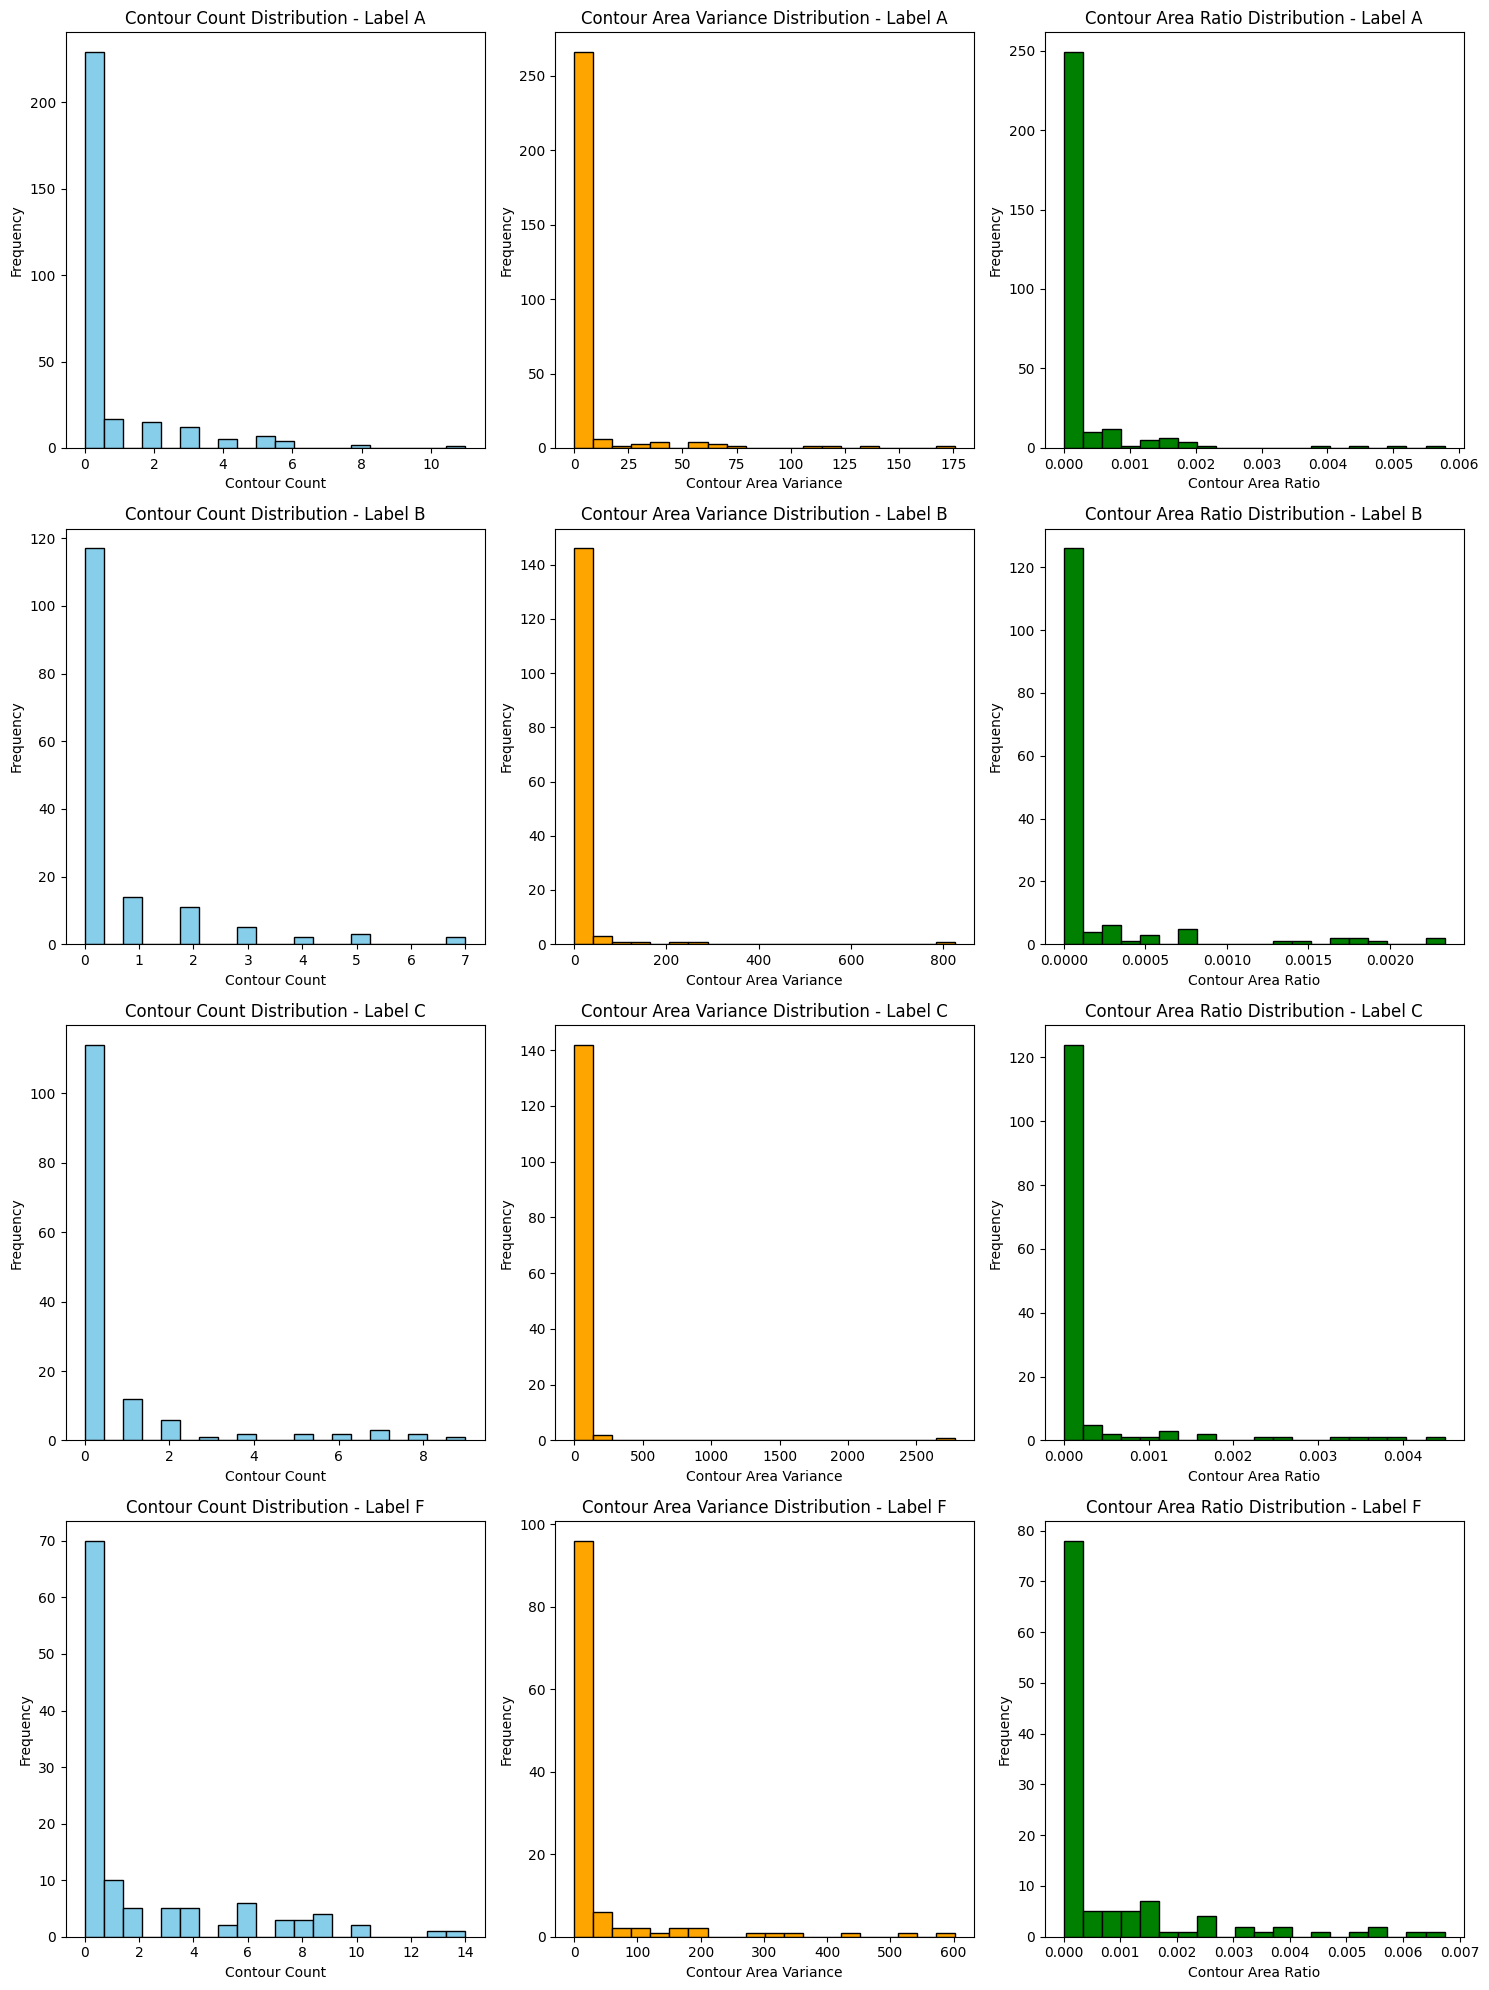

In [437]:
visualize_distribution_by_label(df_results)